In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

In [5]:
batch_fname = BASEDIR / "inputs/short_answer/gpt-4o-2024-08-06/batch.jsonl"
fname = BASEDIR / "outputs/short_answer/gpt-4o-2024-08-06/outputs.jsonl"

batches = read_jsonl(batch_fname)
raw_responses = read_jsonl(fname)
responses = []
for prompt, resp in zip(batches, raw_responses):
    assert prompt["custom_id"] == resp["custom_id"]

    if resp["custom_id"] not in dataset_map:
        continue
    
    contains_system = prompt["body"]["messages"][0]["role"] == "system"
    responses.append(
        {
            "uid": resp["custom_id"],
            "system": prompt["body"]["messages"][0] if contains_system else None,
            "prompt": prompt["body"]["messages"][1:] if contains_system else prompt["body"]["messages"],
            "response": ModelResponse.from_response(resp["response"]["body"], "openai")
        }
    )
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset)

  0%|          | 0/4780 [00:00<?, ?it/s]

Function timed out after 10 seconds
('To determine the set of all real numbers \\( x \\) for which the expression \n\n\\[\n\\log_{2004}(\\log_{2003}(\\log_{2002}(\\log_{2001}{x})))\n\\]\n\nis defined, we need to ensure that each logarithm in the nested expression is defined and positive.\n\n1. **Innermost Logarithm: \\(\\log_{2001}{x}\\):**\n\n   The expression \\(\\log_{2001}{x}\\) is defined if \\( x > 0 \\). Additionally, for \\(\\log_{2001}{x}\\) to be positive, we need:\n\n   \\[\n   \\log_{2001}{x} > 0 \\implies x > 2001^0 = 1\n   \\]\n\n2. **Next Logarithm: \\(\\log_{2002}(\\log_{2001}{x})\\):**\n\n   The expression \\(\\log_{2002}(\\log_{2001}{x})\\) is defined if \\(\\log_{2001}{x} > 0\\). We already have this condition from the previous step. Additionally, for \\(\\log_{2002}(\\log_{2001}{x})\\) to be positive, we need:\n\n   \\[\n   \\log_{2001}{x} > 1 \\implies x > 2001^1 = 2001\n   \\]\n\n3. **Next Logarithm: \\(\\log_{2003}(\\log_{2002}(\\log_{2001}{x}))\\):**\n\n   The e

0.4696652719665272

In [6]:
os.makedirs(BASEDIR / "results/gpt-4o-2024-08-06", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/gpt-4o-2024-08-06/results.csv")

In [7]:
results_metadata.value_counts("reason")

reason
stop      4610
length     170
Name: count, dtype: int64

## Cost

In [8]:
PRICES = get_pricing("gpt-4o-2024-08-06")

total_cost = 0
for row in results_metadata.itertuples():
    total_cost += PRICES["input_tokens"] * row.input_tokens
    total_cost += PRICES["output_tokens"] * row.output_tokens
total_cost

34.892157499999854

## Accuracy

In [9]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,71.464330
2,1505,60.730897
3,1363,42.406456
4,719,20.862309
5,197,10.152284
6,197,6.091371


In [11]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,51.340206
counting_and_probability,812,41.995074
geometry,1268,34.542587
number_theory,601,45.257903
prealgebra,889,70.753656
precalculus,240,27.916667


## Output lengths

<Axes: title={'center': 'output_tokens'}, xlabel='level'>

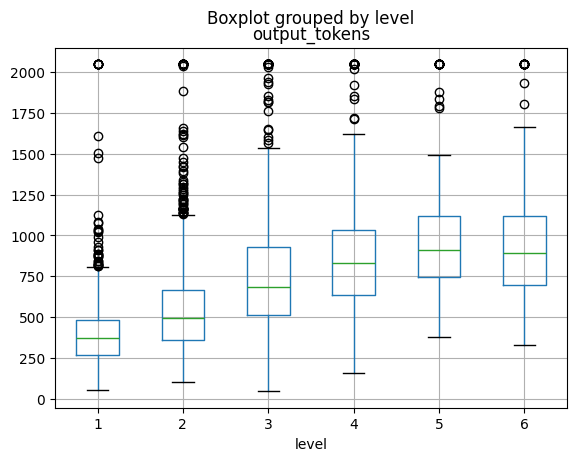

In [12]:
results_metadata.boxplot("output_tokens", "level")

<Figure size 900x600 with 0 Axes>

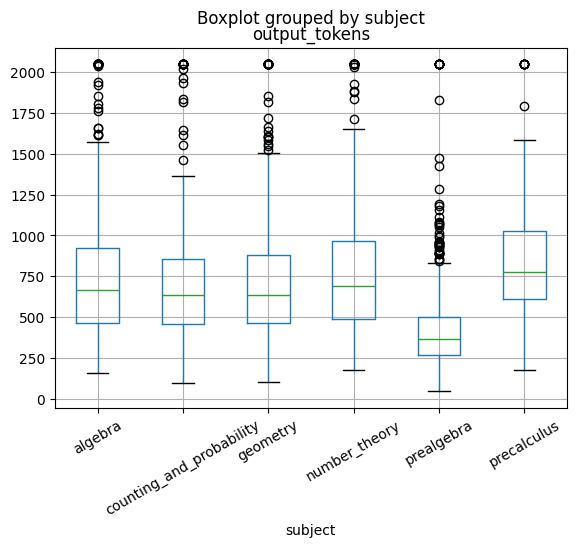

In [13]:
plt.figure(figsize=(9,6))
results_metadata.boxplot("output_tokens", "subject")
plt.xticks(rotation=30)
plt.show()